In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel(r'C:\Users\chang\Desktop\Code\SDSS_group9\data\public_services_dataset.xlsx', sheet_name='dataset')
dictionary = pd.read_excel(r'C:\Users\chang\Desktop\Code\SDSS_group9\data\public_services_dataset.xlsx', sheet_name='dictionary')

# print(f'Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns')
# print(f'Date range: {df.OCCUPANCY_DATE.min().date()} to {df.OCCUPANCY_DATE.max().date()}')
# display(dictionary)

In [110]:
# Column types and nulls
print(df.dtypes.to_string())
print(f'\n--- Null Counts ---')
print(df.isnull().sum().to_string())

OCCUPANCY_DATE            datetime64[ns]
LOCATION_POSTAL_CODE              object
SECTOR                            object
OVERNIGHT_SERVICE_TYPE            object
PROGRAM_MODEL                     object
PROGRAM_AREA                      object
CAPACITY_TYPE                     object
ACTUAL_CAPACITY                    int64
OCCUPIED_CAPACITY                  int64
UNAVAILABLE_CAPACITY               int64
OCCUPANCY_RATE                   float64

--- Null Counts ---
OCCUPANCY_DATE            0
LOCATION_POSTAL_CODE      0
SECTOR                    0
OVERNIGHT_SERVICE_TYPE    0
PROGRAM_MODEL             4
PROGRAM_AREA              0
CAPACITY_TYPE             0
ACTUAL_CAPACITY           0
OCCUPIED_CAPACITY         0
UNAVAILABLE_CAPACITY      0
OCCUPANCY_RATE            0


In [111]:
# Numeric summary
display(df[['ACTUAL_CAPACITY', 'OCCUPIED_CAPACITY', 'UNAVAILABLE_CAPACITY', 'OCCUPANCY_RATE']].describe().round(3))

,ACTUAL_CAPACITY,OCCUPIED_CAPACITY,UNAVAILABLE_CAPACITY,OCCUPANCY_RATE
count,100337.000,100337.000,100337.000,100337.000
mean,53.153,52.452,2.243,0.972
std,50.119,50.235,9.965,0.092
min,1.000,1.000,-10.000,0.020
25%,24.000,23.000,0.000,1.000
50%,39.000,38.000,0.000,1.000
75%,68.000,68.000,1.000,1.000
max,329.000,329.000,171.000,1.016


In [112]:
# Headline stats
pct_full = (df['OCCUPANCY_RATE'] >= 1.0).mean() * 100
pct_over95 = (df['OCCUPANCY_RATE'] >= 0.95).mean() * 100

print('=== HEADLINE STATS ===')
print(f'Mean occupancy rate:              {df.OCCUPANCY_RATE.mean()*100:.1f}%')
print(f'Program-days at 100% capacity:    {pct_full:.1f}%')
print(f'Program-days at ≥95% capacity:    {pct_over95:.1f}%')
print(f'Avg unavailable beds/rooms/day:   {df.UNAVAILABLE_CAPACITY.mean():.1f}')
print(f'Unique locations (postal codes):  {df.LOCATION_POSTAL_CODE.nunique()}')

=== HEADLINE STATS ===
Mean occupancy rate:              97.2%
Program-days at 100% capacity:    78.5%
Program-days at ≥95% capacity:    87.9%
Avg unavailable beds/rooms/day:   2.2
Unique locations (postal codes):  111


In [113]:
# Temporal features
df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'])
df['month'] = df['OCCUPANCY_DATE'].dt.month
df['year'] = df['OCCUPANCY_DATE'].dt.year
df['day_of_week'] = df['OCCUPANCY_DATE'].dt.day_name()
df['week'] = df['OCCUPANCY_DATE'].dt.isocalendar().week.astype(int)
df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',
                                 3:'Spring',4:'Spring',5:'Spring',
                                 6:'Summer',7:'Summer',8:'Summer',
                                 9:'Fall',10:'Fall',11:'Fall'})

In [114]:
# Daily system-wide stats
daily = df.groupby('OCCUPANCY_DATE').agg(
    mean_occ_rate=('OCCUPANCY_RATE', 'mean'),
    median_occ_rate=('OCCUPANCY_RATE', 'median'),
    pct_full=('OCCUPANCY_RATE', lambda x: (x >= 1.0).mean() * 100),
    total_capacity=('ACTUAL_CAPACITY', 'sum'),
    total_occupied=('OCCUPIED_CAPACITY', 'sum'),
    total_unavailable=('UNAVAILABLE_CAPACITY', 'sum')
).round(3)

daily['surplus'] = daily['total_capacity'] - daily['total_occupied']

daily['system_occ_rate'] = (daily['total_occupied'] / daily['total_capacity']).round(3)
print('--- Daily System Stats (first 10 days) ---')
display(daily.head(10))
print(f'\n--- Daily Stats Summary ---')
display(daily.describe().round(3))

--- Daily System Stats (first 10 days) ---


,mean_occ_rate,median_occ_rate,pct_full,total_capacity,total_occupied,total_unavailable,surplus,system_occ_rate
OCCUPANCY_DATE,,,,,,,,
2024-01-01,0.973,1.0,77.778,7692,7594,220,98,0.987
2024-01-02,0.977,1.0,74.815,7703,7616,215,87,0.989
2024-01-03,0.975,1.0,71.111,7703,7620,210,83,0.989
2024-01-04,0.979,1.0,77.037,7704,7630,213,74,0.990
2024-01-05,0.978,1.0,72.593,7700,7624,217,76,0.990
2024-01-06,0.977,1.0,76.296,7690,7599,227,91,0.988
2024-01-07,0.981,1.0,77.612,7645,7573,225,72,0.991
2024-01-08,0.979,1.0,76.119,7632,7555,238,77,0.990
2024-01-09,0.978,1.0,71.111,7709,7611,207,98,0.987



--- Daily Stats Summary ---


,mean_occ_rate,median_occ_rate,pct_full,total_capacity,total_occupied,total_unavailable,surplus,system_occ_rate
count,731.000,731.0,731.000,731.000,731.000,731.000,731.000,731.000
mean,0.973,1.0,78.773,7295.789,7199.607,307.896,96.182,0.987
std,0.016,0.0,7.144,373.152,381.212,127.014,56.947,0.008
min,0.903,1.0,57.042,6618.000,6501.000,117.000,19.000,0.959
25%,0.963,1.0,73.489,7035.000,6907.000,208.000,44.000,0.982
50%,0.976,1.0,79.259,7292.000,7252.000,269.000,91.000,0.987
75%,0.987,1.0,84.791,7513.500,7451.500,394.000,137.500,0.994
max,0.996,1.0,92.308,8169.000,8025.000,642.000,298.000,0.997


In [ ]:
# Monthly breakdown
monthly = df.groupby(['year', 'month']).agg(
    mean_occ_rate=('OCCUPANCY_RATE', 'mean'),
    pct_full=('OCCUPANCY_RATE', lambda x: (x >= 1.0).mean() * 100),
    total_capacity=('ACTUAL_CAPACITY', 'sum'),
    total_occupied=('OCCUPIED_CAPACITY', 'sum'),
    total_unavailable=('UNAVAILABLE_CAPACITY', 'sum'),
    program_count=('OCCUPANCY_RATE', 'count')
).round(3)
monthly['system_occ_rate'] = (monthly['total_occupied'] / monthly['total_capacity']).round(3)
print('--- Monthly Breakdown ---')
display(monthly)

--- Monthly Breakdown ---


mean_occ_rate  pct_full  total_capacity  total_occupied  \
year month                                                            
2024 1              0.982    78.493          239668          237581   
     2              0.983    80.263          224914          223221   
     3              0.985    83.869          233444          231742   
     4              0.986    85.661          223517          222091   
     5              0.989    87.055          231620          230617   
     6              0.984    84.662          222544          221190   
     7              0.990    87.685          228259          227231   
     8              0.991    88.834          225845          224956   
     9              0.991    87.129          215928          214969   
     10             0.988    86.394          222835          221616   
     11             0.980    81.613          216705          214856   
     12             0.963    72.752          235208          230889   
2025 1              0.961    74.707          246518          242166   
     2              0.955    71.851          222858          218391   
     3              0.961    70.107          237269          232260   
     4              0.969    78.169          218406          215069   
     5              0.972    79.337          218582          215531   
     6              0.958    75.426          210819          206673   
     7              0.949    71.451          214961          209973   
     8              0.960    73.520          210525          206658   
     9              0.974    76.737          200084          196970   
     10             0.974    77.903          206355          203408   
     11             0.950    71.844          203807          198589   
     12             0.946    64.393          222551          216266   

            total_unavailable  program_count  system_occ_rate  
year month                                                     
2024 1                   6690           4166            0.991  
     2                   6361           3876            0.992  
     3                   9953           4234            0.993  
     4                   8091           4038            0.994  
     5                   6856           4133            0.996  
     6                   5211           3925            0.994  
     7                   6316           4044            0.995  
     8                   6404           4039            0.996  
     9                   7531           3908            0.996  
     10                  4566           4079            0.995  
     11                  5508           3992            0.991  
     12                  9607           4360            0.982  
2025 1                   6625           4685            0.982  
     2                   5705           4295            0.980  
     3                  11110           4486            0.979  
     4                  10916           4173            0.985  
     5                   9236           4196            0.986  
     6                  11489           4163            0.980  
     7                  13899           4480            0.977  
     8                  17064           4358            0.982  
     9                  16060           3959            0.984  
     10                 16050           4091            0.986  
     11                 11789           4127            0.974  
     12                 12035           4530            0.972

In [15]:
# Year over year comparison
yoy = df.groupby('year').agg(
    mean_occ_rate=('OCCUPANCY_RATE', 'mean'),
    pct_full=('OCCUPANCY_RATE', lambda x: (x >= 1.0).mean() * 100),
    avg_capacity=('ACTUAL_CAPACITY', 'mean'),
    avg_unavailable=('UNAVAILABLE_CAPACITY', 'mean'),
    total_records=('OCCUPANCY_RATE', 'count')
).round(3)
print('--- Year over Year ---')
display(yoy)

--- Year over Year ---


,mean_occ_rate,pct_full,avg_capacity,avg_unavailable,total_records
year,,,,,
2024,0.984,83.627,55.755,1.703,48794
2025,0.961,73.674,50.690,2.755,51543


## By Postal Code

In [63]:
# Set of all postal codes
postal_codes = df['LOCATION_POSTAL_CODE'].unique()
print(f'Total unique postal codes: {len(postal_codes)}')
print(sorted(postal_codes))

# Data for one postal code (change as needed)
# for sample_pc in ['M5A1C1', 'M5A1T3', 'M5A2A5', 'M5A2E5', 'M5A2K9', 'M5A2N2', 'M5A2N3', 'M5A2N9', 'M5A2R5', 'M5A2R9', 'M5A2V2', 'M5A4H5']:
#     df_temp = df[df['LOCATION_POSTAL_CODE'] == sample_pc]
#     print(f'Postal code: {sample_pc} | Rows: {len(df_temp)}')

df_temp = df[df['LOCATION_POSTAL_CODE'] == "M5A2E5"]
dates_present = df_temp['OCCUPANCY_DATE'].dt.date.unique()
print(f"Total rows: {len(df_temp)}")
print(f"Unique dates present: {len(dates_present)}")
print(f"Date range: {min(dates_present)} to {max(dates_present)}")

Total unique postal codes: 111
['L4L8P5', 'M1B3M6', 'M1E2M6', 'M1E2N8', 'M1E2P4', 'M1E2P9', 'M1E2S2', 'M1G1J6', 'M1H2X1', 'M1H2Z1', 'M1K1M2', 'M1K2B5', 'M1L4A1', 'M1M1P8', 'M1P4V8', 'M1R2T5', 'M1T3G2', 'M2H3H9', 'M2J4R1', 'M2J4R2', 'M2K2V5', 'M2M3S3', 'M2M3T3', 'M2N4N4', 'M3B2T5', 'M3L1A5', 'M3M2X4', 'M3N0E3', 'M3N1X1', 'M4C1L7', 'M4K3W5', 'M4M2M5', 'M4M2V8', 'M4M3C3', 'M4M3G9', 'M4T1C1', 'M4W2N1', 'M4X1K9', 'M4X1L4', 'M4Y2H6', 'M4Y2X9', 'M5A1C1', 'M5A1T3', 'M5A2A5', 'M5A2E5', 'M5A2K9', 'M5A2N2', 'M5A2N3', 'M5A2N9', 'M5A2R5', 'M5A2R9', 'M5A2V2', 'M5A4H5', 'M5B1G3', 'M5B1G6', 'M5B1H3', 'M5B2C2', 'M5B2G8', 'M5B2P3', 'M5C1K6', 'M5C2G1', 'M5C2H4', 'M5G1P4', 'M5H1H9', 'M5R1K6', 'M5R2S5', 'M5R2T1', 'M5R2T8', 'M5R2T9', 'M5R2W7', 'M5S2H1', 'M5S2P1', 'M5S2P9', 'M5T1J5', 'M5T1N6', 'M5T2M8', 'M5T2V4', 'M5T2V5', 'M5T2V9', 'M5V1A3', 'M5V2H3', 'M5V3C6', 'M5V3G9', 'M5V3W3', 'M6A2W9', 'M6C2R5', 'M6E4X3', 'M6G1M2', 'M6G2C4', 'M6G2N1', 'M6G3B1', 'M6H1B1', 'M6H1L6', 'M6H3Z5', 'M6J1A8', 'M6J1W4', 'M6K1E9'

## By Service Sector


In [ ]:
# Set of all postal codes
programs = df['PROGRAM_AREA'].unique()
sectors = df["SECTOR"].unique()
print(f'Total unique programs: {len(programs)}')
print(sorted(programs))
print(f'Total unique sectors: {len(sectors)}')
print(sorted(sectors))

# Data Filtration (change as needed)
sample_program_area = "Base Shelter and Overnight Services System"
sample_program_model = "Emergency"
df_men = df[
    (df['PROGRAM_AREA'] == "Base Shelter and Overnight Services System") &
    (df['PROGRAM_MODEL'] == sample_program_model) &
    (df['SECTOR'].isin(['Men']))
]
print(f'Program Area: {sample_program_area} | Rows: {len(df_one)}')
# display(df_one.head(10))
print('=== HEADLINE STATS ===')
print(f'Mean occupancy rate:              {df_one.OCCUPANCY_RATE.mean()*100:.1f}%')
# print(f'Program-days at 100% capacity:    {pct_full:.1f}%')
# print(f'Program-days at ≥95% capacity:    {pct_over95:.1f}%')
print(f'Avg unavailable beds/rooms/day:   {df_one.UNAVAILABLE_CAPACITY.mean():.1f}')
print(f'Unique locations (postal codes):  {df_one.LOCATION_POSTAL_CODE.nunique()}')


Total unique programs: 5
['Base Program - Refugee', 'Base Shelter and Overnight Services System', 'Temporary Programs', 'Temporary Refugee Response', 'Winter Programs']
Total unique sectors: 5
['Families', 'Men', 'Mixed Adult', 'Women', 'Youth']
Program Area: Base Shelter and Overnight Services System | Rows: 14019
=== HEADLINE STATS ===
Mean occupancy rate:              98.5%
Avg unavailable beds/rooms/day:   1.1
Unique locations (postal codes):  15


### Base-System Analysis

In [138]:
# Set of all postal codes
#programs = df['PROGRAM_AREA'].unique()


# Data Filtration (change as needed)
sample_program_area = "Base Shelter and Overnight Services System"
sample_program_model = "Emergency"
df_filtered = df[
    (df['PROGRAM_AREA'] == "Base Shelter and Overnight Services System") &
    (df['OVERNIGHT_SERVICE_TYPE'] != "Top Bunk Contingency Space")
    
]

#print(f'Program Area: {sample_program_area} | Rows: {len(df_filtered)}')

print(sorted(df_filtered['LOCATION_POSTAL_CODE'].unique()))



['M1E2M6', 'M1E2N8', 'M1E2P4', 'M1E2P9', 'M1E2S2', 'M1H2X1', 'M1K1M2', 'M1K2B5', 'M1L4A1', 'M1M1P8', 'M1P4V8', 'M1R2T5', 'M2H3H9', 'M2M3S3', 'M3B2T5', 'M3M2X4', 'M3N0E3', 'M4C1L7', 'M4K3W5', 'M4M2M5', 'M4M2V8', 'M4M3C3', 'M4T1C1', 'M4W2N1', 'M4X1K9', 'M4Y2H6', 'M4Y2X9', 'M5A1C1', 'M5A1T3', 'M5A2A5', 'M5A2N2', 'M5A2N3', 'M5A2N9', 'M5A2R5', 'M5A2R9', 'M5A4H5', 'M5B1G6', 'M5B1H3', 'M5B2P3', 'M5C1K6', 'M5C2G1', 'M5C2H4', 'M5H1H9', 'M5R1K6', 'M5R2T1', 'M5R2W7', 'M5S2P9', 'M5T1J5', 'M5T2M8', 'M5T2V9', 'M5V1A3', 'M5V2H3', 'M5V3G9', 'M5V3W3', 'M6A2W9', 'M6C2R5', 'M6E4X3', 'M6G1M2', 'M6G2C4', 'M6G2N1', 'M6H1B1', 'M6H1L6', 'M6H3Z5', 'M6J1A8', 'M6K1E9', 'M6K3C3', 'M6N3V7', 'M6P1Y5', 'M8Y1A3', 'M9V1P9', 'M9V2X6', 'NAN']


In [129]:
print(sorted(df_filtered['OVERNIGHT_SERVICE_TYPE'].unique()))
print(sorted(df_filtered['PROGRAM_AREA'].unique()))
print(sorted(df_filtered['SECTOR'].unique()))
# Aggregate daily stats for base shelter system
daily_base = df_filtered.groupby('OCCUPANCY_DATE').agg(
    total_capacity=('ACTUAL_CAPACITY', 'sum'),
    total_occupied=('OCCUPIED_CAPACITY', 'sum'),
    total_unavailable=('UNAVAILABLE_CAPACITY', 'sum')
).reset_index()
daily_base['occupancy_rate'] = daily_base['total_occupied'] / daily_base['total_capacity']
daily_base['surplus'] = daily_base['total_capacity'] - daily_base['total_occupied']
daily_base['true_capacity'] = daily_base['total_capacity'] + daily_base['total_unavailable']

for date in ['2024-10-01', '2025-10-01']:
    row = daily_base[daily_base['OCCUPANCY_DATE'] == date]
    print(f"\n=== {date} ===")
    print(f"Total Capacity (Actual):   {row['total_capacity'].values[0]}")
    print(f"Total Occupied:            {row['total_occupied'].values[0]}")
    print(f"Total Unavailable:         {row['total_unavailable'].values[0]}")
    print(f"Funded Capacity:           {row['true_capacity'].values[0]}")
    print(f"Surplus:                   {row['surplus'].values[0]}")
    print(f"Occupancy Rate:            {row['occupancy_rate'].values[0]:.3f}")

['24-Hour Respite Site', "24-Hour Women's Drop-in", 'Motel/Hotel Shelter', 'Shelter']
['Base Shelter and Overnight Services System']
['Families', 'Men', 'Mixed Adult', 'Women', 'Youth']

=== 2024-10-01 ===
Total Capacity (Actual):   3902
Total Occupied:            3869
Total Unavailable:         38
Funded Capacity:           3940
Surplus:                   33
Occupancy Rate:            0.992

=== 2025-10-01 ===
Total Capacity (Actual):   3899
Total Occupied:            3839
Total Unavailable:         196
Funded Capacity:           4095
Surplus:                   60
Occupancy Rate:            0.985


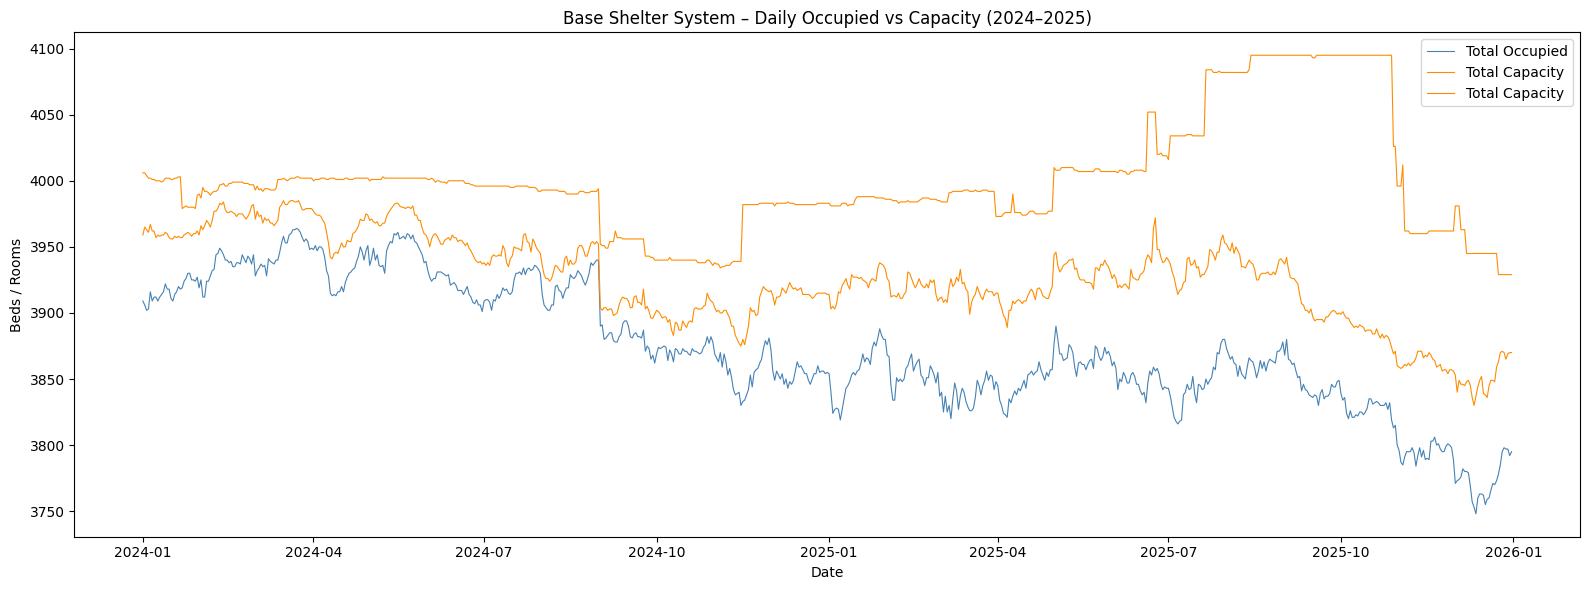

In [116]:

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_base['OCCUPANCY_DATE'], daily_base['total_occupied'], color='steelblue', linewidth=0.8, label='Total Occupied')
ax.plot(daily_base['OCCUPANCY_DATE'], daily_base['total_capacity'], color='darkorange', linewidth=0.8, label='Total Capacity')
ax.plot(daily_base['OCCUPANCY_DATE'], daily_base['true_capacity'], color='darkorange', linewidth=0.8, label='Total Capacity')

ax.set_xlabel('Date')
ax.set_ylabel('Beds / Rooms')
ax.set_title('Base Shelter System – Daily Occupied vs Capacity (2024–2025)')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def snapshot(label, df_snap):
    print(f"\n{'='*60}")
    print(f"  {label}")
    print(f"{'='*60}")
    print(f"  Date:             {df_snap['OCCUPANCY_DATE'].iloc[0].date()}")
    print(f"  Programs:         {len(df_snap)}")
    print(f"  Actual Capacity:  {df_snap['ACTUAL_CAPACITY'].sum()}")
    print(f"  Occupied:         {df_snap['OCCUPIED_CAPACITY'].sum()}")
    print(f"  Unavailable:      {df_snap['UNAVAILABLE_CAPACITY'].sum()}")
    print(f"  Funded Capacity:  {df_snap['ACTUAL_CAPACITY'].sum() + df_snap['UNAVAILABLE_CAPACITY'].sum()}")
    print(f"  Surplus:          {df_snap['ACTUAL_CAPACITY'].sum() - df_snap['OCCUPIED_CAPACITY'].sum()}")
    print(f"  Occupancy Rate:   {df_snap['OCCUPIED_CAPACITY'].sum() / df_snap['ACTUAL_CAPACITY'].sum():.1%}")

    for grouping in ['SECTOR', 'PROGRAM_AREA']:
        summary = df_snap.groupby(grouping).agg(
            Capacity=('ACTUAL_CAPACITY', 'sum'),
            Occupied=('OCCUPIED_CAPACITY', 'sum'),
            Unavailable=('UNAVAILABLE_CAPACITY', 'sum'),
            Programs=('ACTUAL_CAPACITY', 'count')
            
        )
        summary['Occ Rate'] = (summary['Occupied'] / summary['Capacity']).round(3)
        summary['Surplus'] = summary['Capacity'] - summary['Occupied']
        summary['Funded'] = summary['Capacity'] + summary["Unavailable"]
        print(f"\n  --- By {grouping} ---")
        display(summary)

# Filter function
def get_base_date_filtered(date):
    return df[(df['OCCUPANCY_DATE'] == date) &
              (df['PROGRAM_AREA'] == "Base Shelter and Overnight Services System") &
              (df['OVERNIGHT_SERVICE_TYPE'] != "Top Bunk Contingency Space")]
def get_date_filtered_to_base(date):
    return df[(df['OCCUPANCY_DATE'] == date)]

snapshot("BASE SHELTER SYSTEM — Oct 1, 2024", get_date_filtered_to_base('2024-10-01'))
snapshot("BASE SHELTER SYSTEM — Oct 1, 2025", get_date_filtered_to_base('2025-10-01'))




  BASE SHELTER SYSTEM — Oct 1, 2024
  Date:             2024-10-01
  Programs:         131
  Actual Capacity:  7179
  Occupied:         7130
  Unavailable:      237
  Funded Capacity:  7416
  Surplus:          49
  Occupancy Rate:   99.3%

  --- By SECTOR ---


,Capacity,Occupied,Unavailable,Programs,Occ Rate,Surplus
SECTOR,,,,,,
Families,824,817,19,14,0.992,7
Men,2091,2088,101,34,0.999,3
Mixed Adult,2546,2522,101,35,0.991,24
Women,1065,1064,11,26,0.999,1
Youth,653,639,5,22,0.979,14



  --- By PROGRAM_AREA ---


,Capacity,Occupied,Unavailable,Programs,Occ Rate,Surplus
PROGRAM_AREA,,,,,,
Base Program - Refugee,258,256,0,8,0.992,2
Base Shelter and Overnight Services System,3940,3907,38,87,0.992,33
Temporary Programs,1842,1832,101,23,0.995,10
Temporary Refugee Response,1119,1115,1,10,0.996,4
Winter Programs,20,20,97,3,1.000,0



  BASE SHELTER SYSTEM — Oct 1, 2025
  Date:             2025-10-01
  Programs:         132
  Actual Capacity:  6651
  Occupied:         6543
  Unavailable:      552
  Funded Capacity:  7203
  Surplus:          108
  Occupancy Rate:   98.4%

  --- By SECTOR ---


,Capacity,Occupied,Unavailable,Programs,Occ Rate,Surplus
SECTOR,,,,,,
Families,735,725,28,14,0.986,10
Men,1893,1857,248,33,0.981,36
Mixed Adult,2292,2262,181,37,0.987,30
Women,998,987,87,23,0.989,11
Youth,733,712,8,25,0.971,21



  --- By PROGRAM_AREA ---


,Capacity,Occupied,Unavailable,Programs,Occ Rate,Surplus
PROGRAM_AREA,,,,,,
Base Program - Refugee,257,252,0,8,0.981,5
Base Shelter and Overnight Services System,3923,3856,201,88,0.983,67
Temporary Programs,1510,1503,143,20,0.995,7
Temporary Refugee Response,961,932,208,16,0.970,29
